# Amazon Fine Food Review
#### Attribute Information:
1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### Objective:
The main objective is to determine weather a review is positive or negative,where score 4,5 are positive and 1,2 are negative reviews 3 been neutral

In [1]:
#importing the required packages
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [2]:
# using the SQLite Table to read data.
connection = sqlite3.connect('database.sqlite')

In [3]:
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews       
WHERE Score != 3
""", connection) 

def partition(x): #this function converts the score into positive and negative
    if x < 3:
        return 'negative'
    return 'positive'


In [4]:
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

### Data Cleaning(EDA)

In [5]:
#deduplication
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
final_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
#in above code the duplicate values are removed
final_data.shape

(364173, 10)

In [7]:
final_data=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]
#in above code where HelpfulnessNumerator less than are equal Helpfulnessdenominator are removed

In [8]:
final_data['Score'].value_counts() #gives the positive and negative values count

positive    307061
negative     57110
Name: Score, dtype: int64

In [9]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #stopwords are stored in stop variable
sno = nltk.stem.SnowballStemmer('english') 

def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [10]:
#text preprocessing
i=0
str1=' '
final_string=[]
all_positive_words=[]
all_negative_words=[] 
s=''
for sent in final_data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence)
    final_string.append(str1)
    i+=1

In [11]:
final_data['CleanedText']=final_string #reviews which are preprocessed

In [12]:
positive_reviews_data=final_data[final_data.Score=='positive']
negative_reviews_data=final_data[final_data.Score=='negative']

In [13]:
positive_reviews_data.shape

(307061, 11)

In [14]:
final_positive=positive_reviews_data[['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary','Text','CleanedText']]
score_positive=positive_reviews_data[['Score']]
final_negative=negative_reviews_data[['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary','Text','CleanedText']]
score_negative=negative_reviews_data[['Score']]

In [15]:
frames=[final_positive.head(2000),final_negative.head(2000)]
final_4k=pd.concat(frames)
frame=[score_positive.head(2000),score_negative.head(2000)]
final_score_4k=pd.concat(frame)

### Bag of Words on 4k dataset

In [16]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(final_4k['Text'].values)

### T-SNE on 4k dataset using BoW

In [17]:
from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)

In [18]:
tsne_data = model.fit_transform(final_counts.toarray())

In [19]:
tsne_data = np.column_stack((tsne_data,final_score_4k))
tsne_df_bow= pd.DataFrame(data=tsne_data,columns=("Dim_1", "Dim_2", "Score"))

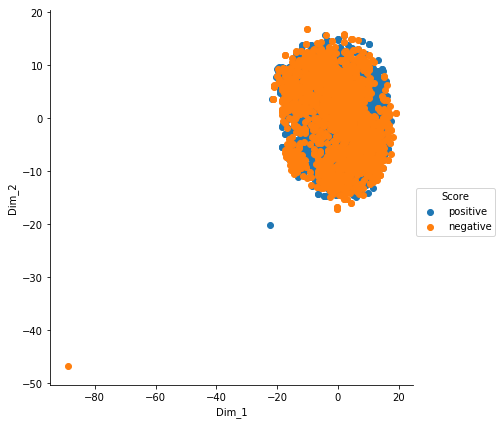

In [20]:
sns.FacetGrid(tsne_df_bow, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### TF-IDF on 4k dataset

In [21]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_4k['Text'].values)

In [22]:
tsne_data_tfidf= model.fit_transform(final_tf_idf.toarray())

In [23]:
tsne_data_tfidf = np.column_stack((tsne_data_tfidf,final_score_4k))
tsne_df_tfidf= pd.DataFrame(data=tsne_data_tfidf,columns=("Dim_1", "Dim_2", "Score"))

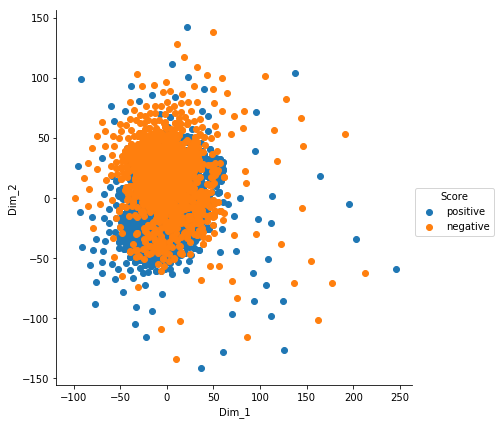

In [24]:
sns.FacetGrid(tsne_df_tfidf, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Avg W2V

In [25]:
import gensim
i=0
list_of_sent=[]
for sent in final_4k['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

C:\Users\RAJAVARUN\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [26]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    

In [27]:
sent_vectors = []; 
for sent in list_of_sent:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

4000
50


### T-SNE  on 4k dataset

In [28]:
tsne_data_avgw2v= model.fit_transform(sent_vectors)

In [29]:
tsne_data_avgw2v = np.column_stack((tsne_data_avgw2v,final_score_4k))
tsne_df_avgw2v= pd.DataFrame(data=tsne_data_avgw2v,columns=("Dim_1", "Dim_2", "Score"))

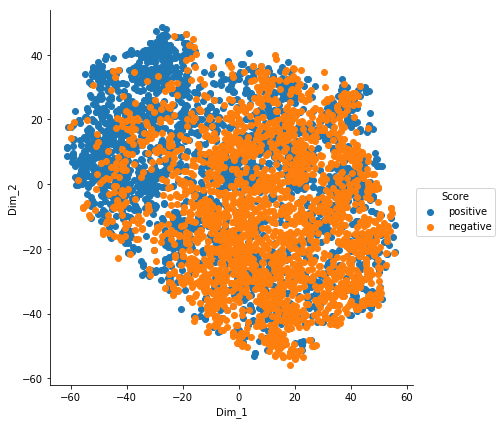

In [30]:
sns.FacetGrid(tsne_df_avgw2v, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### TFIDF-W2V on 4k dataset

In [31]:
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vectors = []; 
row=0;
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [32]:
tsne_data_tfidfw2v= model.fit_transform(tfidf_sent_vectors)

In [33]:
tsne_data_tfidfw2v = np.column_stack((tsne_data_tfidfw2v,final_score_4k))
tsne_df_tfidfw2v= pd.DataFrame(data=tsne_data_tfidfw2v,columns=("Dim_1", "Dim_2", "Score"))

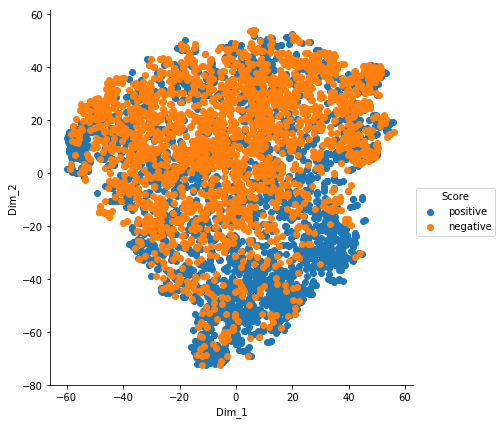

In [34]:
sns.FacetGrid(tsne_df_tfidfw2v, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### Conclusion:
* The objective is to determine wheather a review is positive or not and to reduce the dimension of the dataset
* When the data is loaded the score values from numeric values is converted in string values i.e positive and negative
* Positive:4,5
* Neutral:3 
* Negative:1,2
* Later the data cleaning is done where duplicate values(reviews)
* Then text preprocessing is done where a reviews are converted in lowercase,stopwords are removed,stemming of words is done
* From 364k rowds, 4k rows are been taken where 2k rows are positive reviedws and rest of the 2k reviews are negative reviews
* First the dataset text is taken and converted into vectors using BoW algorithm
* Later this vectors dimension is reduced by using T-SNE algorithm 
* The reduced dimension vectors are plotted for representation
* The same method is repeated for the vectors derived from TF-IDF,Avg W2V,TFIDF-W2v algorithms for dimens